# Train a Production Model

In this tutorial, you will use the existing hyperparameters that yielded the best performing model in the previous **Tutorial 7** to train a production model on the full dataset, rather than just the training subset from a scaffold split. Training a model on the full dataset is one approach for creating a production model. Another approach, not demonstrated in this tutorial, is to combine the training and validation subsets for training and evaluating with the test subset. **[K-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_\(statistics\)#k-fold_cross-validation)** makes use of this approach. The production model could be shared with other researchers to predict on new data. 

We will use the functions below to retrain the best original model for production and compare the production model with the original model. **We use the word "retrain" here to describe 
creating a new model based on the same hyperparameters; retraining doesn't replace the existing model.** 

We will use functions covered in **Tutorial 5** to evaluate the original and production models on an external test dataset.

- [create_prediction_pipeline_from_file](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.model_pipeline.create_prediction_pipeline_from_file)
- [train_model_from_tar](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_model_from_tar)

>**Notes:**
>*1. `train_model_from_tar` and other functions in the `model_retrain` module can be used to update a previously trained model when there is a new **[AMPL](https://github.com/ATOMScience-org/AMPL)** release that is not compatible with previous versions. This is not covered in this tutorial.
>2. When a model input dataset is updated with additional data, the model should be trained from scratch with a new hyperparameter optimization run; *then* a new version of the production model can be generated*. 

## Import Packages

In [1]:
import pandas as pd
import os
from atomsci.ddm.utils import model_retrain as mr
from atomsci.ddm.utils import model_version_utils as mv
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import predict_from_model as pfm
from atomsci.ddm.pipeline import perf_plots as pp
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

2024-03-20 15:04:08.496794: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 15:04:08.541563: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 15:04:08.541650: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 15:04:08.541686: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 15:04:08.549942: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 15:04:08.550953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Start from saved best model

We're using the best performing model by validation set $R^2$ from **Tutorial 7**. This was a random forest model. The model path, validation set $R^2$
and RF-specific parameters were as follows:

>dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz

>Best valid r2 score:  0.5595899501867392

>Model Parameters:  {"rf_estimators": 129, "rf_max_depth": 32, "rf_max_features": 95}

When you load a previously trained model, either for running predictions or retraining, the parameters used to train the model are obtained from a file called 'model_metadata.json' that is stored
in the model's .tar.gz file. The `production` parameter controls whether the data is split into training, validation and test sets. During normal training and hyperparameter optimization, the 
`production` parameter is set False; setting it True causes all splitting related parameters to be ignored. When you call `train_model_from_tar` with the `production` argument set True, the code
overrides the `production` parameter in the model parameters to set it True, so that all the data is used for training.

In the following code, `create_prediction_pipeline_from_file` is used to reload the original best model. We then verify that it was trained with `production` set to `False`. 

We also check the **[AMPL](https://github.com/ATOMScience-org/AMPL)** version to make sure the saved model was trained with a version of **[AMPL](https://github.com/ATOMScience-org/AMPL)** that is compatible with the installed version. The versions must be compatible in order to be used by `create_prediction_pipeline_from_file`, which we will be calling later to run predictions from the saved model.

In [2]:
#Tutorial 7 RF saved model_path
best_model_path='dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz'

#get installed AMPL version
print("installed AMPL version: " + str(mv.get_ampl_version()))

#get AMPL model version
print("best model AMPL version: " + str(mv.get_ampl_version_from_model(best_model_path)))

# check versions are compatible
assert(mv.check_version_compatible(best_model_path))

#load best model production params
best_model_pipe = mp.create_prediction_pipeline_from_file(params=None, reload_dir=None, model_path=best_model_path, model_type='best_model', featurization=None, verbose=False)

#show production is false
print("orig_params.production: " + str(best_model_pipe.orig_params.production))

INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz version = "1.6", AMPL version = "1.6"
INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz version = "1.6", AMPL version = "1.6"


installed AMPL version: 1.6.1
best model AMPL version: 1.6.0


orig_params.production: False


## Retrain best model as production model

Setting the `production` argument for `train_model_from_tar` to `True` will set `production=True` in the model params. If the `production` argument for `train_model_from_tar` is `False`, the model will be retrained without changing any parameters. Note the production model's model parameter `production` is set to `True`.

In [3]:
odir='dataset/SLC6A3_models'

production_model = mr.train_model_from_tar(input=best_model_path, output=odir, production=True)

#check for parameters
print("production_model.params.production: " + str(production_model.params.production))
print("production_model.params.model_tarball_path: " + str(production_model.params.model_tarball_path))

print("production model AMPL version: " + str(mv.get_ampl_version_from_model(production_model.params.model_tarball_path)))

INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_ee11dd2d-51fa-4a89-b42f-c2832a50ff21.tar.gz, 1.6.1


production_model.params.production: True
production_model.params.model_tarball_path: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_ee11dd2d-51fa-4a89-b42f-c2832a50ff21.tar.gz
production model AMPL version: 1.6.1


## Compare performance on a separate external test dataset

Here we will apply **Tutorial 5**'s steps to run predictions with the original best model and the production model, using an independent dataset of 
compounds that are structurally different (with Tanimoto distance > 0.4) from all compounds in the production dataset. We use this approach
to compare the performance of the two models. Since the production model is trained on all data, including the test subset, the original 
test subset **should not** be used to evaluate its performance.

First we'll load the external test dataset, which we've already featurized with **[RDKit](https://github.com/rdkit/rdkit)** descriptors:

In [4]:
test_file_path = 'dataset/scaled_descriptors/SLC6A3_Ki_ext_test_data_with_rdkit_raw_descriptors.csv'
test_data = pd.read_csv(test_file_path)

test_data.head()

,compound_id,base_rdkit_smiles,avg_pKi,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,compound_346,OC(C[NH2+]C1CCC1)C1(c2ccc(Cl)c(Cl)c2)CCC1,7.958607,8.970106,-4.751902,8.970106,0.825260,0.861181,315.264,293.088,...,0,0,0,0,0,0,0,0,0,0
1,compound_225,CN1Cc2ccccc2C(C)(c2ccc3[nH]ncc3c2)C1,6.587660,8.993202,-4.010824,8.993202,0.226986,0.739733,277.371,258.219,...,0,0,0,0,0,0,0,0,0,0
2,compound_166,O=C(O)C(/C=C/c1ccccc1)C1CCN(CCOC(c2ccccc2)c2cc...,5.430275,13.525088,-5.060732,13.525088,1.095764,0.412331,455.598,422.334,...,0,0,0,0,0,0,0,0,0,0
3,compound_310,CN1Cc2cc(-c3cccnn3)ccc2C(C)(c2cc3ccccc3[nH]2)C1,6.000000,9.204719,-4.140132,9.204719,0.018450,0.581059,354.457,332.281,...,0,0,0,0,0,0,0,0,0,0
4,compound_284,CN1Cc2ccccc2C(F)(c2ccc3sccc3c2)C1,6.587660,17.710445,-4.117619,17.710445,0.229708,0.636234,297.398,281.270,...,0,0,0,0,0,0,0,1,0,0


We now predict $pK_i$ values with the original best model:

In [5]:
id_col = 'compound_id'
smiles_col = 'base_rdkit_smiles'
response_col = 'avg_pKi'

best_pred_df = pfm.predict_from_model_file(model_path = best_model_path, 
                                      input_df = test_data,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False) #throws error if is_featurized=True
                                      
best_pred_df.head()

Standardizing SMILES strings for 533 compounds.


INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz, 1.6.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9b6c9332-15f3-4f96-9579-bf407d0b69a8.tar.gz version = "1.6", AMPL version = "1.6"


,compound_id,base_rdkit_smiles,avg_pKi,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,orig_smiles,avg_pKi_actual,avg_pKi_pred,avg_pKi_std
0,compound_346,OC(C[NH2+]C1CCC1)C1(c2ccc(Cl)c(Cl)c2)CCC1,7.958607,8.970106,-4.751902,8.970106,0.825260,0.861181,315.264,293.088,...,0,0,0,0,0,0,OC(C[NH2+]C1CCC1)C1(c2ccc(Cl)c(Cl)c2)CCC1,7.958607,7.284956,0.955853
1,compound_225,CN1Cc2ccccc2C(C)(c2ccc3[nH]ncc3c2)C1,6.587660,8.993202,-4.010824,8.993202,0.226986,0.739733,277.371,258.219,...,0,0,0,0,0,0,CN1Cc2ccccc2C(C)(c2ccc3[nH]ncc3c2)C1,6.587660,7.143886,0.801133
2,compound_166,O=C(O)C(/C=C/c1ccccc1)C1CCN(CCOC(c2ccccc2)c2cc...,5.430275,13.525088,-5.060732,13.525088,1.095764,0.412331,455.598,422.334,...,0,0,0,0,0,0,O=C(O)C(/C=C/c1ccccc1)C1CCN(CCOC(c2ccccc2)c2cc...,5.430275,7.676473,0.947577
3,compound_310,CN1Cc2cc(-c3cccnn3)ccc2C(C)(c2cc3ccccc3[nH]2)C1,6.000000,9.204719,-4.140132,9.204719,0.018450,0.581059,354.457,332.281,...,0,0,0,0,0,0,CN1Cc2cc(-c3cccnn3)ccc2C(C)(c2cc3ccccc3[nH]2)C1,6.000000,6.379872,1.014355
4,compound_284,CN1Cc2ccccc2C(F)(c2ccc3sccc3c2)C1,6.587660,17.710445,-4.117619,17.710445,0.229708,0.636234,297.398,281.270,...,0,0,0,1,0,0,CN1Cc2ccccc2C(F)(c2ccc3sccc3c2)C1,6.587660,6.949374,0.964244


Now we'll run predictions on the same dataset with the production model:

In [6]:
prod_pred_df = pfm.predict_from_model_file(model_path = production_model.params.model_tarball_path, 
                                      input_df = test_data,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=False)
                                      
prod_pred_df.head()

Standardizing SMILES strings for 533 compounds.


INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_ee11dd2d-51fa-4a89-b42f-c2832a50ff21.tar.gz, 1.6.1
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_ee11dd2d-51fa-4a89-b42f-c2832a50ff21.tar.gz version = "1.6", AMPL version = "1.6"


,compound_id,base_rdkit_smiles,avg_pKi,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,orig_smiles,avg_pKi_actual,avg_pKi_pred,avg_pKi_std
0,compound_346,OC(C[NH2+]C1CCC1)C1(c2ccc(Cl)c(Cl)c2)CCC1,7.958607,8.970106,-4.751902,8.970106,0.825260,0.861181,315.264,293.088,...,0,0,0,0,0,0,OC(C[NH2+]C1CCC1)C1(c2ccc(Cl)c(Cl)c2)CCC1,7.958607,7.339332,0.787900
1,compound_225,CN1Cc2ccccc2C(C)(c2ccc3[nH]ncc3c2)C1,6.587660,8.993202,-4.010824,8.993202,0.226986,0.739733,277.371,258.219,...,0,0,0,0,0,0,CN1Cc2ccccc2C(C)(c2ccc3[nH]ncc3c2)C1,6.587660,6.531313,1.254926
2,compound_166,O=C(O)C(/C=C/c1ccccc1)C1CCN(CCOC(c2ccccc2)c2cc...,5.430275,13.525088,-5.060732,13.525088,1.095764,0.412331,455.598,422.334,...,0,0,0,0,0,0,O=C(O)C(/C=C/c1ccccc1)C1CCN(CCOC(c2ccccc2)c2cc...,5.430275,6.986682,0.722916
3,compound_310,CN1Cc2cc(-c3cccnn3)ccc2C(C)(c2cc3ccccc3[nH]2)C1,6.000000,9.204719,-4.140132,9.204719,0.018450,0.581059,354.457,332.281,...,0,0,0,0,0,0,CN1Cc2cc(-c3cccnn3)ccc2C(C)(c2cc3ccccc3[nH]2)C1,6.000000,5.953689,1.092239
4,compound_284,CN1Cc2ccccc2C(F)(c2ccc3sccc3c2)C1,6.587660,17.710445,-4.117619,17.710445,0.229708,0.636234,297.398,281.270,...,0,0,0,1,0,0,CN1Cc2ccccc2C(F)(c2ccc3sccc3c2)C1,6.587660,6.577993,1.288376


To compare the performance of the production model with the original best model, we'll compute the $R^2$ scores for the predictions
from each model and then plot the predicted vs actual values:

In [7]:
best_r2 = np.round(r2_score(best_pred_df.avg_pKi_actual.values, best_pred_df.avg_pKi_pred.values), 6)
prod_r2 = np.round(r2_score(prod_pred_df.avg_pKi_actual.values, prod_pred_df.avg_pKi_pred.values), 6)
print("Best model r2_score: " + str(best_r2))
print("Production model r2_score: " + str(prod_r2))

Best model r2_score: 0.156877
Production model r2_score: 0.266679


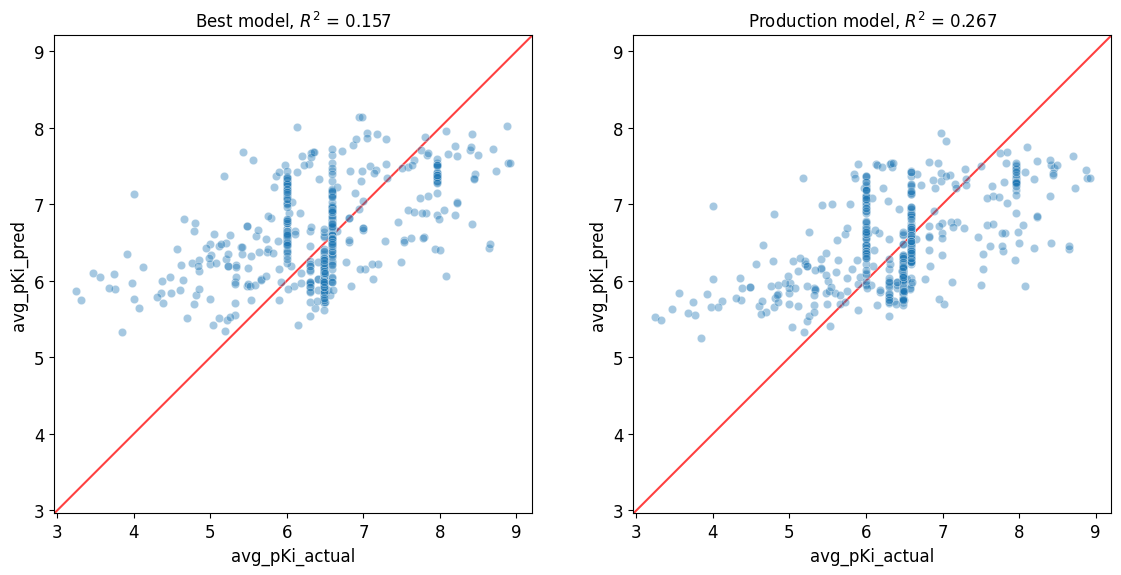

In [8]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
pp.plot_pred_vs_actual_from_df(best_pred_df, actual_col='avg_pKi_actual', pred_col='avg_pKi_pred', 
    label=f"Best model, $R^2$ = {best_r2:.3f}", ax=ax[0])
pp.plot_pred_vs_actual_from_df(prod_pred_df, actual_col='avg_pKi_actual', pred_col='avg_pKi_pred', 
    label=f"Production model, $R^2$ = {prod_r2:.3f}", ax=ax[1])
fig.tight_layout(pad=3.0)
fig.show()

Although neither model has a great $R^2$ score, the production model *does* perform better, with $R^2$ = 0.267 vs 0.157 for the original best model.
Also, the points in the production model plot are slightly more concentrated along the diagonal. A possible explanation for the
mediocre performance is that the external dataset compounds were filtered so that none have Tanimoto distance  < 0.4 to any 
compound in the original model dataset, so that the test set compounds are outside of the 
**[applicability domain](https://en.wikipedia.org/wiki/Applicability_domain)** of both models.
We expect that the models' performance would improve on a dataset filtered with a smaller **[Tanimoto distance](https://en.wikipedia.org/wiki/Jaccard_index#Tanimoto_similarity_and_distance)**  threshold.

Developing models that generalize well to diverse sets of compounds (i.e., that have a broader applicability domain) is one of the major
challenges in machine learning for chemistry. Training a `production model` is one approach to this problem. To do better we may need to explore
other model types or methods of featurizing molecules, with additional rounds of `hyperparameter optimization`.

## Other functions with production parameters
A boolean `production` parameter is available in these other functions in the **[AMPL](https://github.com/ATOMScience-org/AMPL)** `model_retrain` module. 
If `production` is set to True, the model will be trained in 
production mode, using the entire dataset for training. Note that for neural network models, the model will be trained for the number of epochs
corresponding to the best epoch from the original model training run.
- [train_model](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_model)
- [train_models_from_dataset_keys](https://ampl.readthedocs.io/en/latest/utils.html#utils.model_retrain.train_models_from_dataset_keys)

In the next tutorial, we'll explore a wide range of methods for visualizing and evaluating the performance of **[AMPL](https://github.com/ATOMScience-org/AMPL)** models.